# 2 : Help


I need help, or to be honest HELP needs help, quite confusing isn't it? 
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.

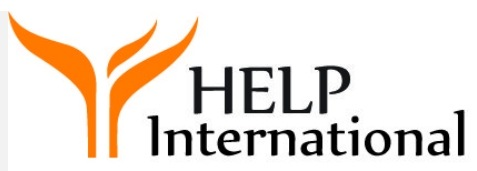

The CEO of HELP has open questioned the data enthusiasts to help him choosing countries that are in the direst need of aid, using his data records about 167 different countries' economical situation on Kaggle. Using various information like the the economic snapshot, inflation, fertility & more we should decide on who needs the aid first.

So our plan is basicaly as this, we will categorize this data into groups, study them, figure out who needs help & develop a semi-supervised model that can identify whether an unseen country record needs aid or not.

## EDA

Without further to do let us dive into the dataset with our well known tradition of EDA.

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv('help.csv',index_col = 'country')
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


As we can see here we imported pandas & seaborn libraries for wrangling & plotting respectively. We imported our dataset with the country name column as the frames index. I prefer to do this as it eases data navigation & doesn't include this nominal variable in our calculations. You can quicky identify what those variables mean to us through [here !](https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data?select=data-dictionary.csv)

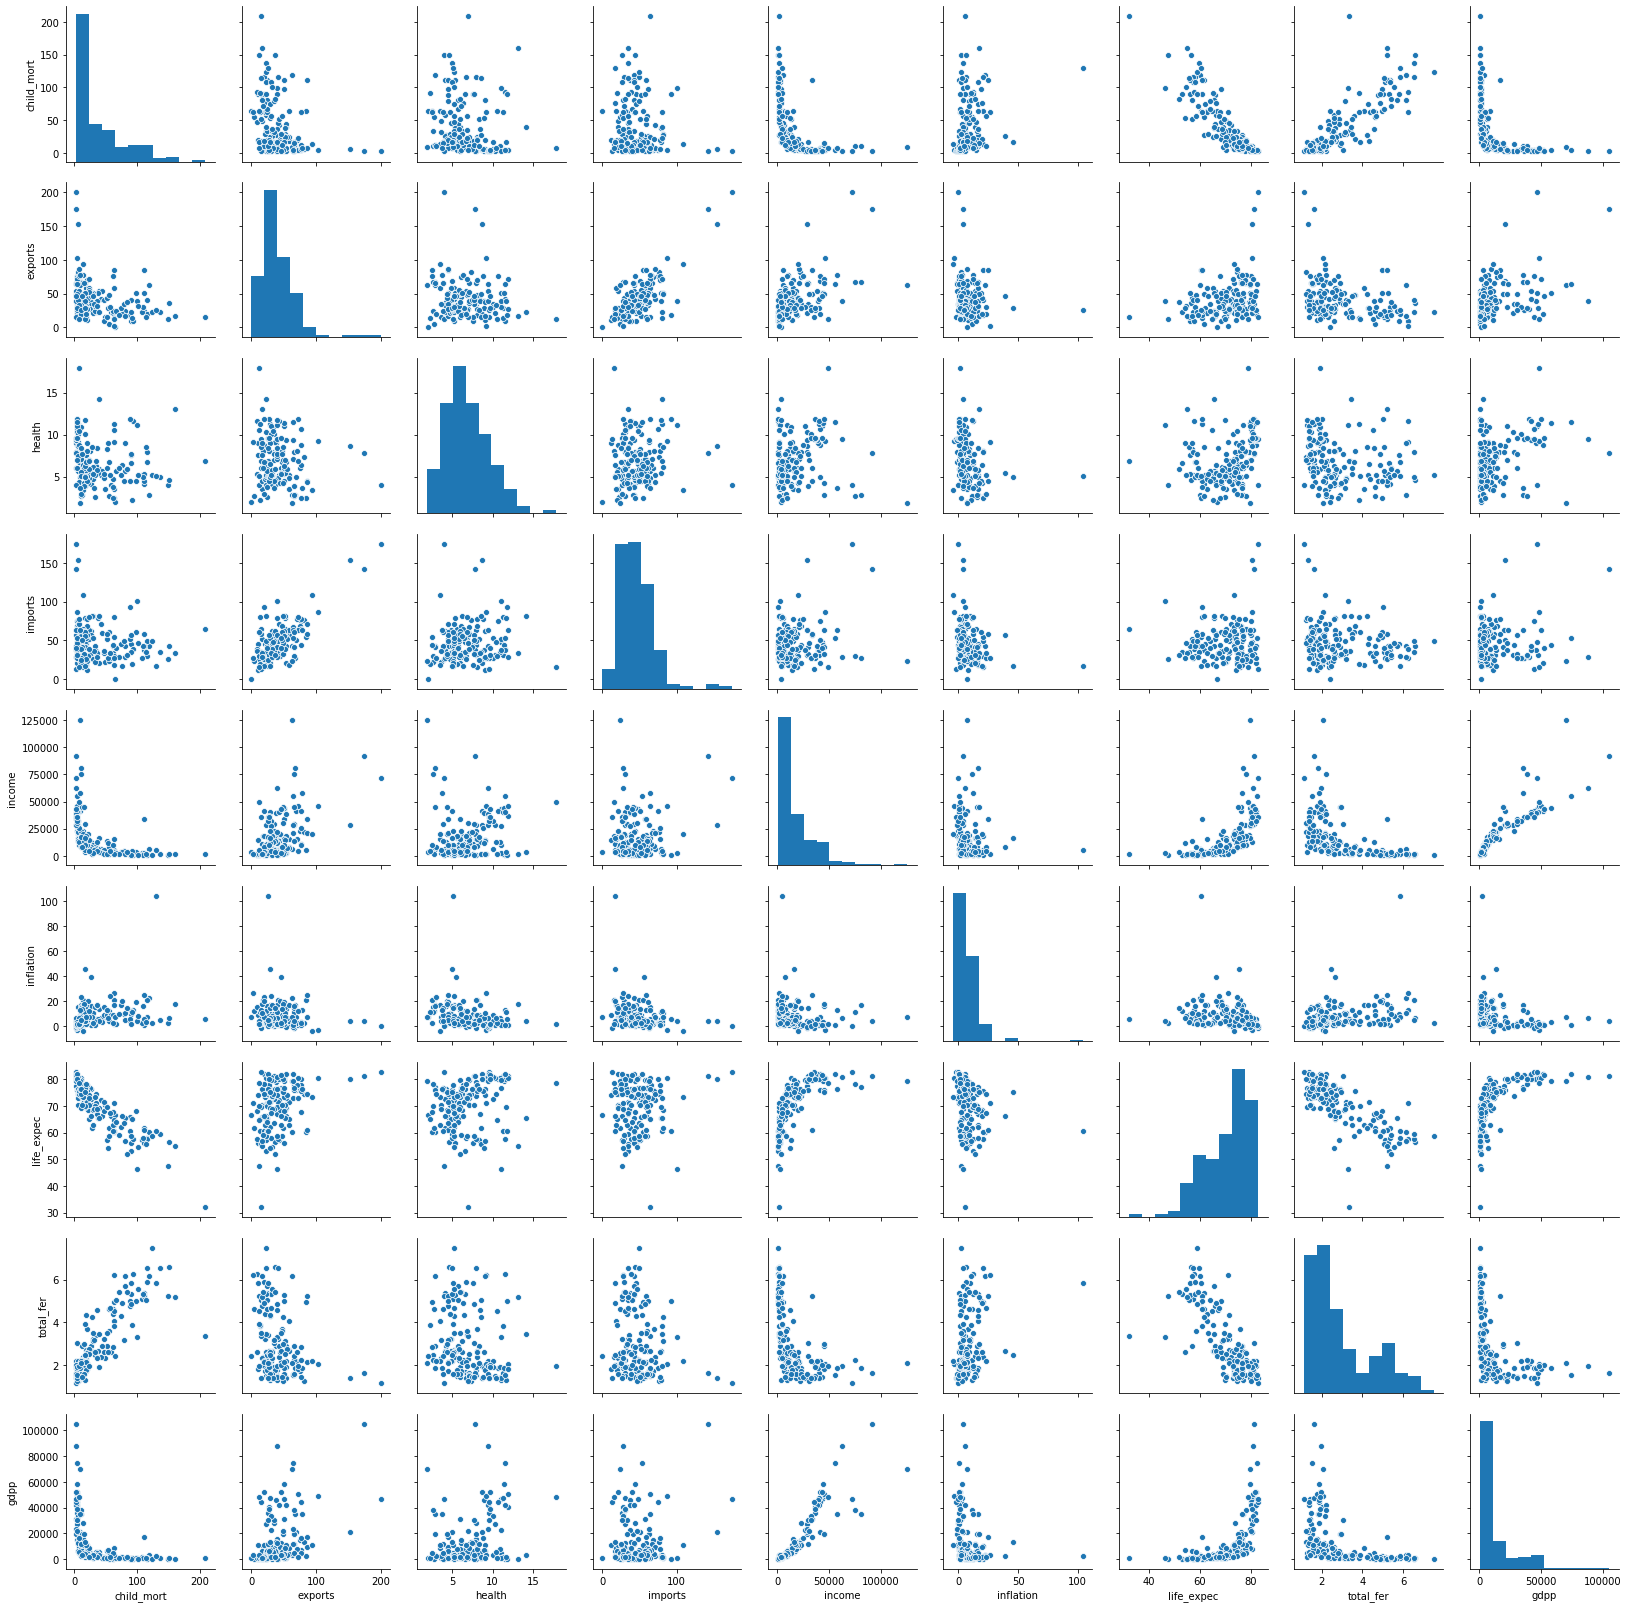

In [58]:
sns.pairplot(data)

This beautiful humongous matrix of plots is the seaborn pair plot, I consider it one of the best EDA options that can be considered. You can see our variables names written on the major axes of the matrix, intersections between two variables are a scatter plot of the two, while the diagonals are a histogram of a single variable.

We can see some interesting patterns between the variables, like the positive correlation between exports & imports, or the negative correlation between child mortality (deathes among children) & life expec (age expected for death). Such interesting patterns mean the we will have to do some interesting work on our data.

### Exploring variances

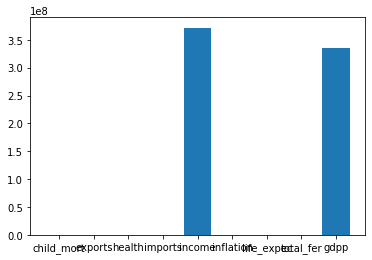

[1626.422712646996, 751.4182983488203, 7.545116239809542, 586.1041983921236, 371643894.1554721, 111.73978097171923, 79.08850660125535, 2.2917343842435605, 335941419.96356666]


In [59]:
var_arr = [col[1].var() for col in data.iteritems()]
plt.bar(x = data.columns,height=var_arr)
plt.show()
print(var_arr)

We can observe that the variance plot is kind of bugged, some variables doesn't appear on the graph even though they exist. The reason is the rest of the variances are massive, we can see them in the printed array below the graph. This data definitly requires sacling.

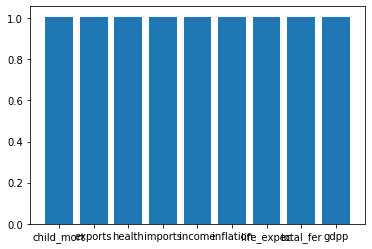

[1.0060240963855422, 1.0060240963855427, 1.0060240963855425, 1.006024096385543, 1.006024096385542, 1.0060240963855418, 1.0060240963855422, 1.0060240963855425, 1.0060240963855422]


In [60]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = data.columns
scaled_data.index = data.index
var_arr = [col[1].var() for col in scaled_data.iteritems()]
plt.bar(x = scaled_data.columns,height=var_arr)
plt.show()
print(var_arr)

Now I'm reliefed, scaling is very important for both clustering & modeling data. It resets a varaible's mean to zero & it's standard deviation / variance to one without changing the original information. This is possible with some statistics work, we subtract the mean from each point then divide by the standard deviation so we get what's called the Z score, there are many ways of scaling and standardization but that's enough talking for this point.

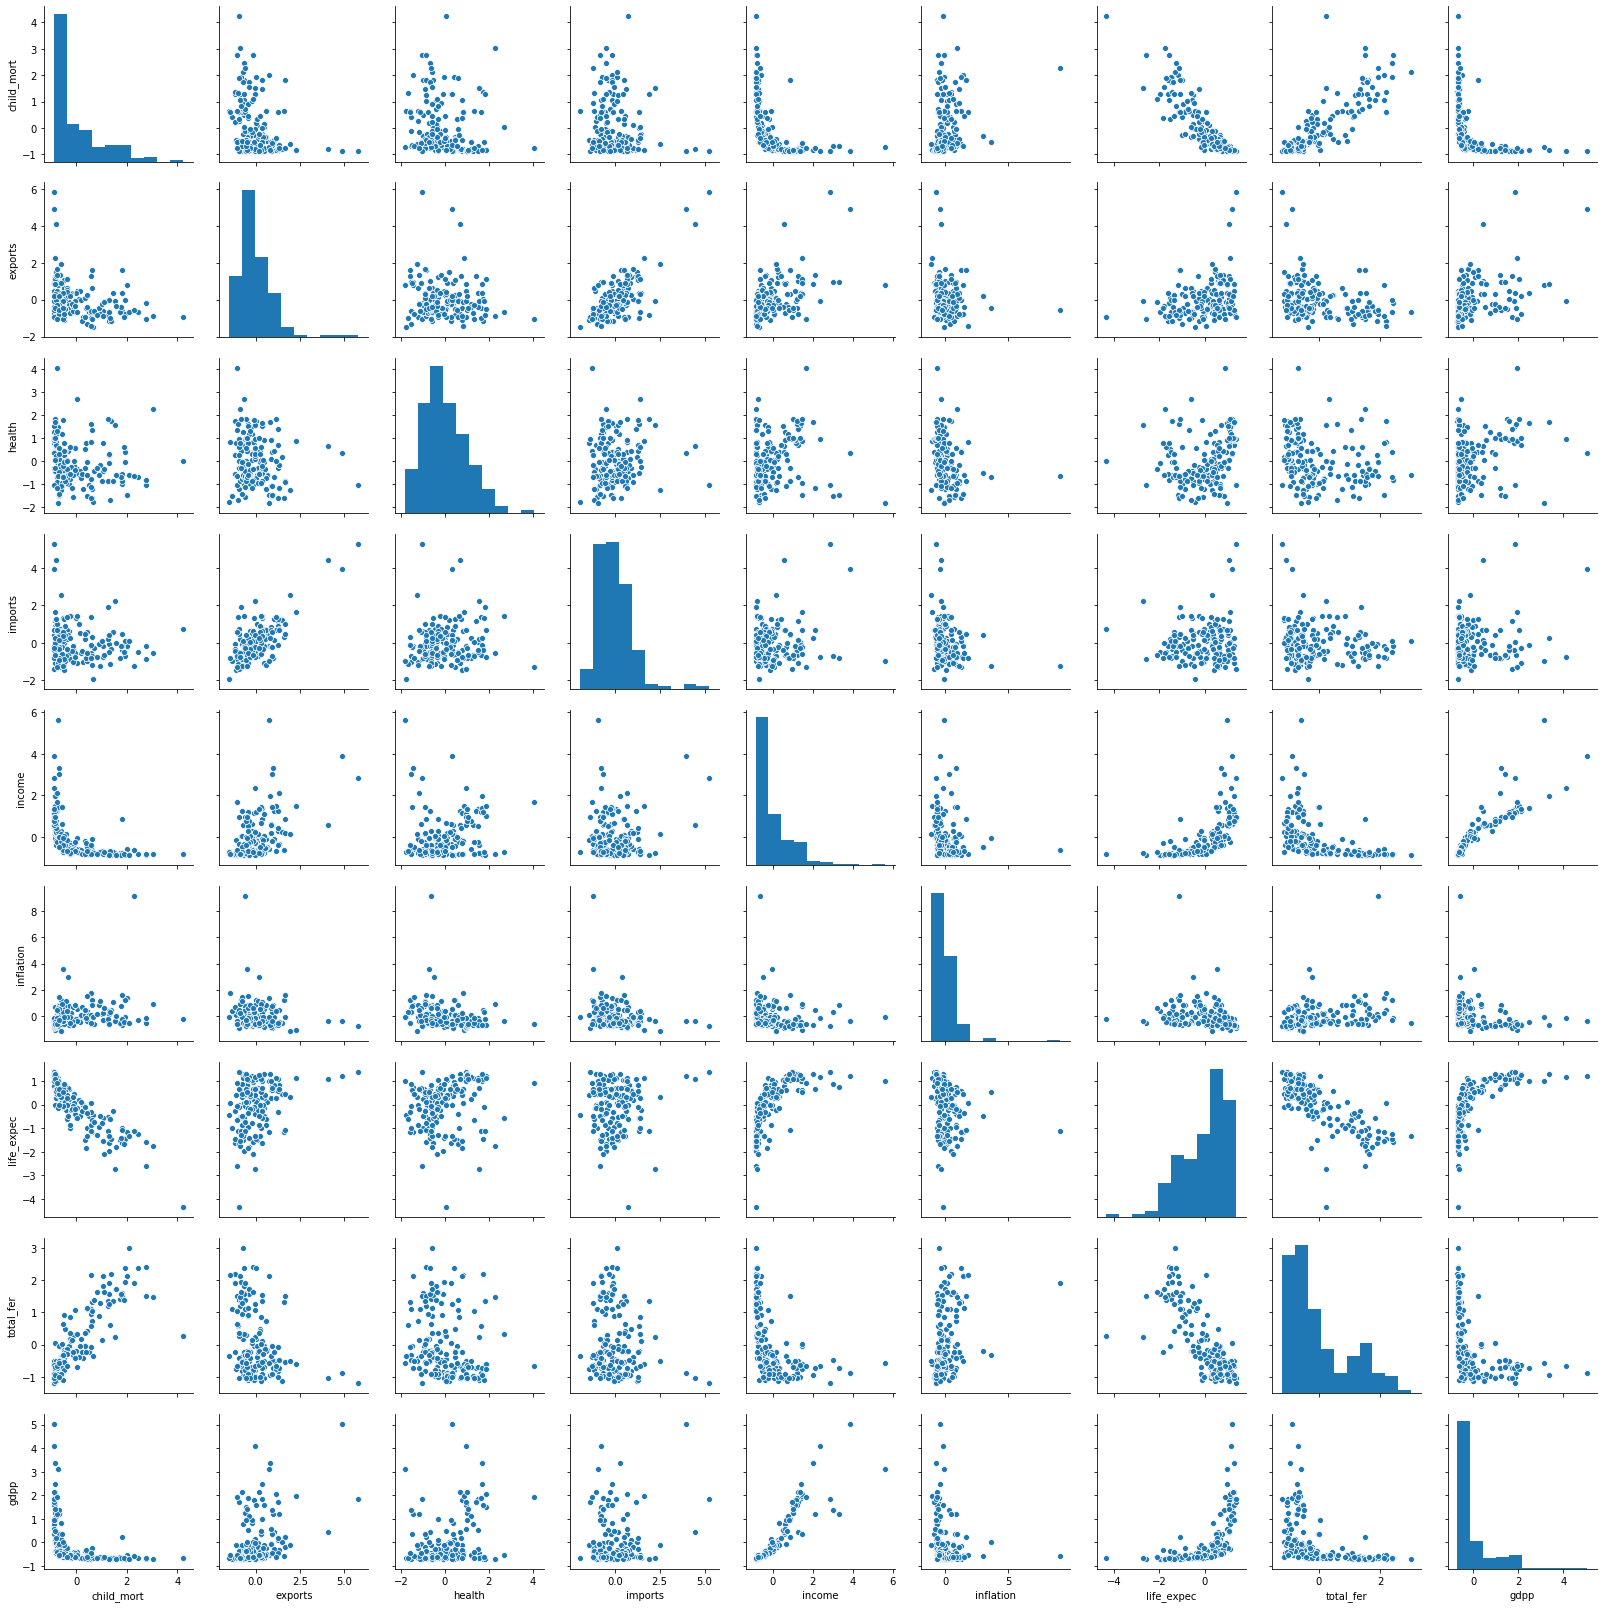

In [61]:
sns.pairplot(scaled_data)

To prove this concept, here is the pairplot once again, comparing it to the top one they are actually the same with same patterns, which proves that information is still the same.

## Preproccessing & dimensionality reduction

Now it is time to preprocess the data & do some feature engineering

In [62]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA()
reduced_data = pca.fit_transform(scaled_data)
reduced_data = pd.DataFrame(reduced_data)
reduced_data.index = data.index
np.cumsum(pca.explained_variance_ratio_)

array([0.4595174 , 0.63133365, 0.76137624, 0.87190786, 0.94530998,
       0.97015232, 0.98275663, 0.99256944, 1.        ])

We imported principal component analysis class PCA() from the decomposition module of sklearn & the numpy package too. The we reduce the data into its principal components. PCA is an interesting way to reduce a dataset's number of features for better clustering & modeling. Then we transform our scaled data into its principal components. Then we check the explained variance ratio cumulative sum.

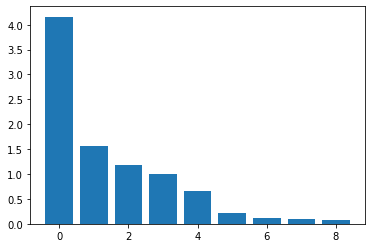

In [63]:
reduced_data.head()
var_arr = [col[1].var() for col in reduced_data.iteritems()]
plt.bar(x = reduced_data.columns,height=var_arr)
plt.show()

We can see that most of the explained variance of the data lies in the first 5 principal components, we shall keep those 5 & bin the rest so we reduced our data from 9 features to only 5.

In [64]:
reduced_data = reduced_data.iloc[:,0:5]
reduced_data.head()

,0,1,2,3,4
country,,,,,
Afghanistan,-2.913025,0.095621,-0.718118,1.005255,-0.158310
Albania,0.429911,-0.588156,-0.333486,-1.161059,0.174677
Algeria,-0.285225,-0.455174,1.221505,-0.868115,0.156475
Angola,-2.932423,1.695555,1.525044,0.839625,-0.273209
Antigua and Barbuda,1.033576,0.136659,-0.225721,-0.847063,-0.193007


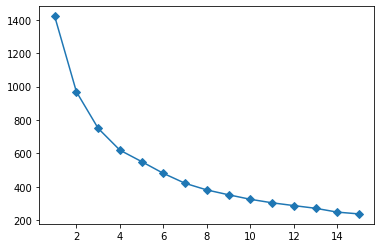

In [65]:
from sklearn.cluster import KMeans
ks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
inertias = []
for k in ks :
    model = KMeans(n_clusters = k,random_state = 1)
    model.fit(reduced_data)
    inertias.append(model.inertia_)
    
plt.plot(ks,inertias,marker = "D")
plt.show()

The previous cell performs clustering by the KMeans technique, the KMeans technique is centroid based clustering, which means it needs the number of clusters pre-defined. But what is the suitable number of clusters? That is determined by the elbow plot.
We know that for a clustering a lower inertia is better, we explained that in epsiode 1. So we chose the number of clusters which the inertia doesn't decrease so much after it . In this case I picked 5 clusters to be our number of clusters.

In [66]:
model = KMeans(n_clusters = 5,random_state = 1)
data['cluster'] = model.fit_predict(reduced_data)
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


Now we have our points clustered, those clusters are unknown to us. We need to investigate each & every one of them & identify their properties.

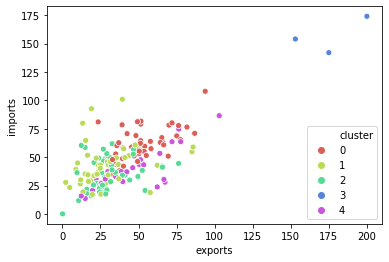

In [67]:
sns.scatterplot(data.exports,data.imports,hue= data.cluster,palette = sns.color_palette("hls", 5))

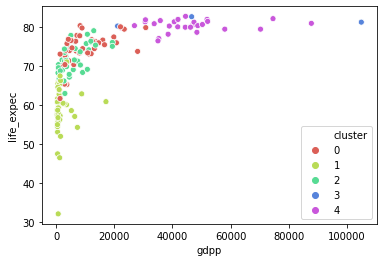

In [68]:
sns.scatterplot(data.gdpp,data.life_expec,hue= data.cluster,palette = sns.color_palette("hls", 5))

What caought my attention are clusters number 1 & 3. Cluster 1 are countries with low gdp per cap , low imports & low exports. This cluster may involve countries that actually in need of aid. Cluster number 3 is the exact opposite, which mean that we can cross them out of our dataset.

In [69]:
print(list(data[data.cluster == 3].index))
print(list(data[data.cluster == 1].index))

['Luxembourg', 'Malta', 'Singapore']
['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia']


As we expected cluster 3 includes Singapore, which is a highly developed free-market economy. Singapore's economy has been ranked as the most open in the world. Luxembourg which enjoys the highest per capita gross domestic product in the world. Malta which is a highly industrialised, service-based economy. It is classified as an advanced economy by the International Monetary Fund. These countries can provide aid not the reverse. So I guess we can corss them out.

In [70]:
data_1 = data.drop(data[data.cluster == 3].index,axis = 0)

While cluster 1 contains mostly African countries, some of them may consider being aided, others don't like South Africa for example which we can observe in the following plot. That makes us uncertain about them, we need to explore other clusters.

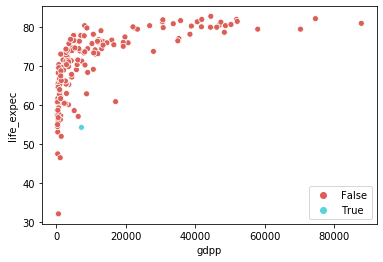

In [71]:
sns.scatterplot(data_1.gdpp,data_1.life_expec,hue= data_1.index.str.startswith('South Africa'),palette = sns.color_palette("hls", 2))

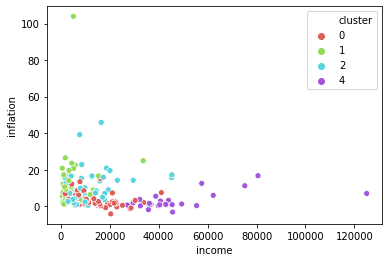

In [72]:
sns.scatterplot(data_1.income,data_1.inflation,hue= data_1.cluster,palette = sns.color_palette("hls", 4))

In exploring the inflation situation in comparison of an average person's income, we find interesting pattern mostly in cluster 4. This cluster tends to have relatively high income with low inflation. Remember inflation bad & income good, which tells us we should explore cluster 4 & whether we should cross them out or not.

In [73]:
print(list(data_1[data_1.cluster == 4].index))


['Australia', 'Austria', 'Belgium', 'Brunei', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait', 'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Qatar', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom', 'United States']


Appearntly Cluster 4 contained the Developed country, developed countries don't need aid so we can cross them out.

In [74]:
data_2 = data_1.drop(data_1[data_1.cluster == 4].index,axis = 0)

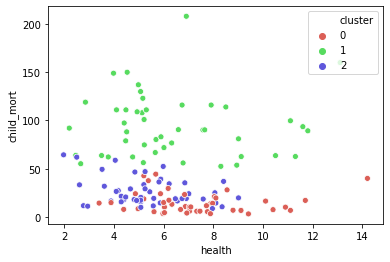

In [75]:
sns.scatterplot(data_2.health,data_2.child_mort,hue= data_2.cluster,palette = sns.color_palette("hls", 3))

This plot of health expediture & child mortality shows a cool pattern. The upper side is dominated by cluster 1 which we suspect to need aid, while the lower part is dominated by clusters 0 & 2. Upper half means high child mortality whatever the health expends are & lower half tells the opposite.

Let us explore the fertility distribution of fertility for the remaining clusters.

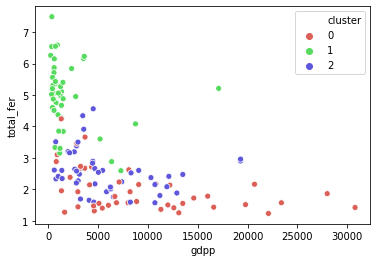

In [76]:
sns.scatterplot(data_2.gdpp,data_2.total_fer,hue= data_2.cluster,palette = sns.color_palette("hls", 3))

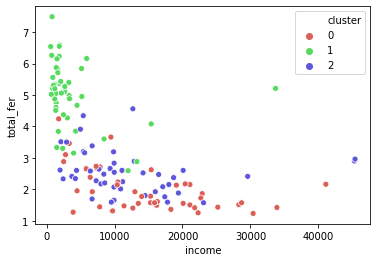

In [77]:
sns.scatterplot(data_2.income,data_2.total_fer,hue= data_2.cluster,palette = sns.color_palette("hls", 3))

Those two plots explore the total fertility as a function of both average personal income & gdp per cap. It's obvious that cluster 1 have huge fertility rates with low income & gdp per cap, now we're pretty sure that countries in cluster 1 may probably need financial aid, while other clusters are good to go.

Let's encode that into our data

In [78]:
data['need_aid'] = (data['cluster'] == 1).astype(int)
data = data.drop('cluster',axis = 1)
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,need_aid
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


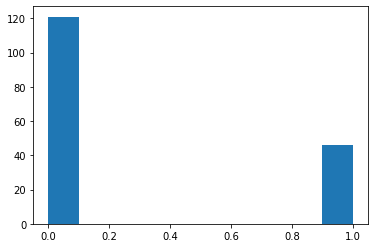

In [81]:
plt.hist(x = data['need_aid'])
plt.show()

Here we encoded the cluster column into the need_aid column, all that we need is whether the country belongs to Cluster 1 that needs aid or not, then we drop the cluster column as we don't need it anymore. Now we need to process the data for modeling.

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV , train_test_split
from sklearn.feature_selection import RFE
import warnings

warnings.filterwarnings('ignore')

X = data.drop('need_aid',axis = 1)
y = data.need_aid
logreg = LogisticRegression(random_state  = 1)

grid = {'C':[0.001,0.01,0.1,1,10,100],'penalty':['l1','l2']}
search = GridSearchCV(estimator = logreg,param_grid = grid)
search.fit(X_train,y_train)

print(search.best_score_)
print(search.best_params_)

0.984
{'C': 0.1, 'penalty': 'l1'}


That is one big pile of code, lets break it down. First we import some classes, the logistic regression, gridsearch that allows us to identify the best hyper-parameters for our model, the train test split function to split our data & the recursive feature eleminator to eleminate features that may cause noise. 

Finally, we import the warning class th remove annoying warnings produced by ipython. Then intialize the estimator & most importantly we define a prameter grid, a dictionary of parameters names & lists of possible values to be set for it. Here we are setting the regularization strength & type, C & penalty respectively. We fit the search & print out the best parameters it found.

In [89]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
rfe = RFE(logreg,20)
rfe.fit(scaled_X,y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1]


To be sure, we scaled our data again before assessing our features what is important & what is not. Ironically the feature selection algorithm ranked every feature as critical to the data. Now lets split the data & train the model.

In [91]:
import numpy as np
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size = 0.3,stratify = y)
logreg = LogisticRegression(random_state = 1,C = 0.1,penalty = 'l1')
logreg.fit(X_train,y_train)
train_acc = np.sum(logreg.predict(X_train) == y_train) / len(y_train)
print(train_acc)

0.9827586206896551


Good news !! We achieved 98 % of accuracy on the train test, we need to identify several quality metrics on the test set.

In [92]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = logreg.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.9803921568627451
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        37
           1       0.93      1.00      0.97        14

    accuracy                           0.98        51
   macro avg       0.97      0.99      0.98        51
weighted avg       0.98      0.98      0.98        51



Amazing !! We achieved nearly the same score in the test set, which means our model is near perfection. I encourage you to learn about the other quality metrics appearing in the classification report. Let's write one cool function that HELP Ceo can use to identify whether the country record suggests it's need to aid or not.

In [98]:
def follow_MuhammadEzzatHBK(record):
    scaled_record = scaler.fit_transform(record)
    return logreg.predict(scaled_record)

# test

print(follow_MuhammadEzzatHBK(X_test))

[0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 1 0 0 0 1 0 0 1 0 1 0 0 1 0]


So we wrote our custom function that decides the status of the country, I claerly have no idea why it's named like that tho.

If you liked this epsiode consider following the repo for more episodes, I'll see you on the next one. GooooodByeeee.